### Imports

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.initializers import GlorotNormal
import keras
import random

# Data preperation

In [19]:
# Read large datasets
data_ALL = pd.read_csv("current_csv_files/data_ALL.csv", index_col='date_forecast')
test_ALL = pd.read_csv("current_csv_files/test_ALL.csv", index_col='date_forecast')

In [20]:
# Separate features and target variable
X = data_ALL.drop('target', axis='columns')
y = data_ALL['target']

X_train_est = data_ALL[ data_ALL['est'] == 1 ].drop('target', axis='columns')
y_train_est = data_ALL[ data_ALL['est'] == 1 ]['target']

# Normalize the feature columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_est_scaled = scaler.fit_transform(X_train_est)
X_kaggle = scaler.fit_transform(test_ALL)

# Create train/test/val datasets
val_index = int(np.floor(len(X_scaled)*0.88))
test_index = int(np.floor(len(X_scaled)*0.94))

X_train = X_scaled[:val_index]
y_train = y[:val_index]

X_val = X_scaled[val_index:test_index]
y_val = y[val_index:test_index]

X_test = X_scaled[test_index:]
y_test = y[test_index:]

X_val_test = X_scaled[val_index:]
y_val_test = y[val_index:]


# Checking the shapes of the splits
(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape, X_train_est.shape, y_train_est.shape)

((76980, 51),
 (76980,),
 (5249, 51),
 (5249,),
 (5249, 51),
 (5249,),
 (11037, 51),
 (11037,))

In [21]:
# Insert all data
"""
X_train = X_scaled
y_train = y
"""

'\nX_train = X_scaled\ny_train = y\n'

In [22]:
# To filter train data
"""
# Filter out x% of training data. Only for kaggle predictions
all_indices = np.arange(X_train.shape[0])
train_indices = np.random.choice(all_indices, int(0.8 * X_train.shape[0]), replace=False)
excluded_indices = np.setdiff1d(all_indices, train_indices)

train_indices.sort()
excluded_indices.sort()

X_train_subsample = X_train.iloc[train_indices]
y_train_subsample = y_train.iloc[train_indices]

# Create a test set from the excluded rows
X_test_specific = X_train.iloc[excluded_indices]
y_test_specific = y_train.iloc[excluded_indices]

#history = model.fit(X_train_subsample, y_train_subsample, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])

#prediction = model.predict(X_test_specific)

#print(i, " MAE: ", mean_absolute_error(y_test_specific, prediction))
"""

'\n# Filter out x% of training data. Only for kaggle predictions\nall_indices = np.arange(X_train.shape[0])\ntrain_indices = np.random.choice(all_indices, int(0.8 * X_train.shape[0]), replace=False)\nexcluded_indices = np.setdiff1d(all_indices, train_indices)\n\ntrain_indices.sort()\nexcluded_indices.sort()\n\nX_train_subsample = X_train.iloc[train_indices]\ny_train_subsample = y_train.iloc[train_indices]\n\n# Create a test set from the excluded rows\nX_test_specific = X_train.iloc[excluded_indices]\ny_test_specific = y_train.iloc[excluded_indices]\n\n#history = model.fit(X_train_subsample, y_train_subsample, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])\n\n#prediction = model.predict(X_test_specific)\n\n#print(i, " MAE: ", mean_absolute_error(y_test_specific, prediction))\n'

# Model training

In [24]:
class CustomModelCheckpoint(Callback):
    def __init__(self, best_weights, i):
        self.best_weights = best_weights  # Dictionary to store best weights
        self.best_loss = np.inf
        self.model_index = i  # Index to handle the specific model in the list

    def on_epoch_end(self, epoch, logs=None):
        # Monitor the validation loss
        current_val_loss = logs.get('val_loss')
        if current_val_loss < self.best_loss:
            # Update the best loss and best weights
            self.best_loss = current_val_loss
            self.best_weights[self.model_index] = self.model.get_weights()

In [25]:
seeds = [ random.randint(0, 100) for _ in range(6) ]
#seeds = [23, 34, 23, 60, 68, 78]
inits = [ HeNormal(seed=s) for s in seeds ]
print(seeds)

N = 10
nets = []

# Initialize dictionary to store the best weights for each model
best_weights_during_training = {}

for i in range(N):
    # Define the Keras model
    model = Sequential([
        Dense(150, input_dim=X_train.shape[1], activation='tanh', kernel_initializer=inits[0]),
        #Dropout(0.2, (150,), seed=seeds[5]),
        Dense(120, activation='relu', kernel_initializer=inits[1]),
        #Dense(120, activation='relu', kernel_initializer=inits[2], kernel_regularizer=l2(0.05)),
        Dense(90, activation='relu', kernel_initializer=inits[2]),
        Dense(60, activation='relu', kernel_initializer=inits[3]),
        Dense(1, activation='relu', kernel_initializer=inits[4])
    ])
    nets.append(model)

    opt = Adam(learning_rate=0.001, beta_1=0.99)
    model.compile(loss='mean_absolute_error', optimizer=opt)

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10)

    # Create an instance of the custom checkpoint for the current model
    custom_checkpoint = CustomModelCheckpoint(best_weights_during_training, i)

    # Fit the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_train_est_scaled, y_train_est),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping, custom_checkpoint]
    )

    # Store the best weights for the current model
    if i not in best_weights_during_training:
        # If the model didn't improve, just save the last weights
        best_weights_during_training[i] = model.get_weights()

    # Plot pred
    """
    plt.figure(figsize=(20, 7))
    plt.plot(prediction, alpha=0.5)
    plt.ylabel('Predicted Target Values')
    plt.show()
    """

    

[84, 61, 30, 15, 21, 97]
Epoch 1/100
2406/2406 [==============================] - 3s 986us/step - loss: 125.2998 - val_loss: 100.0363
Epoch 2/100
2406/2406 [==============================] - 2s 886us/step - loss: 97.2020 - val_loss: 98.6051
Epoch 3/100
2406/2406 [==============================] - 2s 876us/step - loss: 94.5197 - val_loss: 90.4245
Epoch 4/100
2406/2406 [==============================] - 2s 843us/step - loss: 92.1113 - val_loss: 102.4847
Epoch 5/100
2406/2406 [==============================] - 2s 914us/step - loss: 91.7121 - val_loss: 104.0928
Epoch 6/100
2406/2406 [==============================] - 2s 846us/step - loss: 89.9889 - val_loss: 95.2737
Epoch 7/100
2406/2406 [==============================] - 2s 868us/step - loss: 88.2696 - val_loss: 94.3287
Epoch 8/100
2406/2406 [==============================] - 2s 859us/step - loss: 88.8494 - val_loss: 93.7710
Epoch 9/100
2406/2406 [==============================] - 2s 1ms/step - loss: 86.5467 - val_loss: 93.4985
Epoch 10/1

# Making prediction

In [26]:
# Make predictions using the best test validation epoch
best_preds = []

for i in range(N):
    nets[i].set_weights(best_weights_during_training[i])
    best_preds.append(nets[i].predict(X_train_est_scaled).ravel()) # Select dataset of choice
    print(i, "MAE: ", mean_absolute_error(y_train_est, best_preds[i]))

345/345 [==============================] - 0s 375us/step
0 MAE:  90.42444382596193
345/345 [==============================] - 0s 397us/step
1 MAE:  85.87556676845726
345/345 [==============================] - 0s 356us/step
2 MAE:  82.86574777188432
345/345 [==============================] - 0s 349us/step
3 MAE:  81.15528315744787
345/345 [==============================] - 0s 358us/step
4 MAE:  85.02020008993175
345/345 [==============================] - 0s 348us/step
5 MAE:  85.24118838279912
345/345 [==============================] - 0s 352us/step
6 MAE:  88.59880382468266
345/345 [==============================] - 0s 382us/step
7 MAE:  84.75789449582233
345/345 [==============================] - 0s 373us/step
8 MAE:  82.49380306568746
345/345 [==============================] - 0s 379us/step
9 MAE:  87.99493158434223


In [31]:
# Create dataframe
df_best_preds = pd.DataFrame(best_preds).T

df_best_preds['avg'] = df_best_preds.mean(axis='columns')

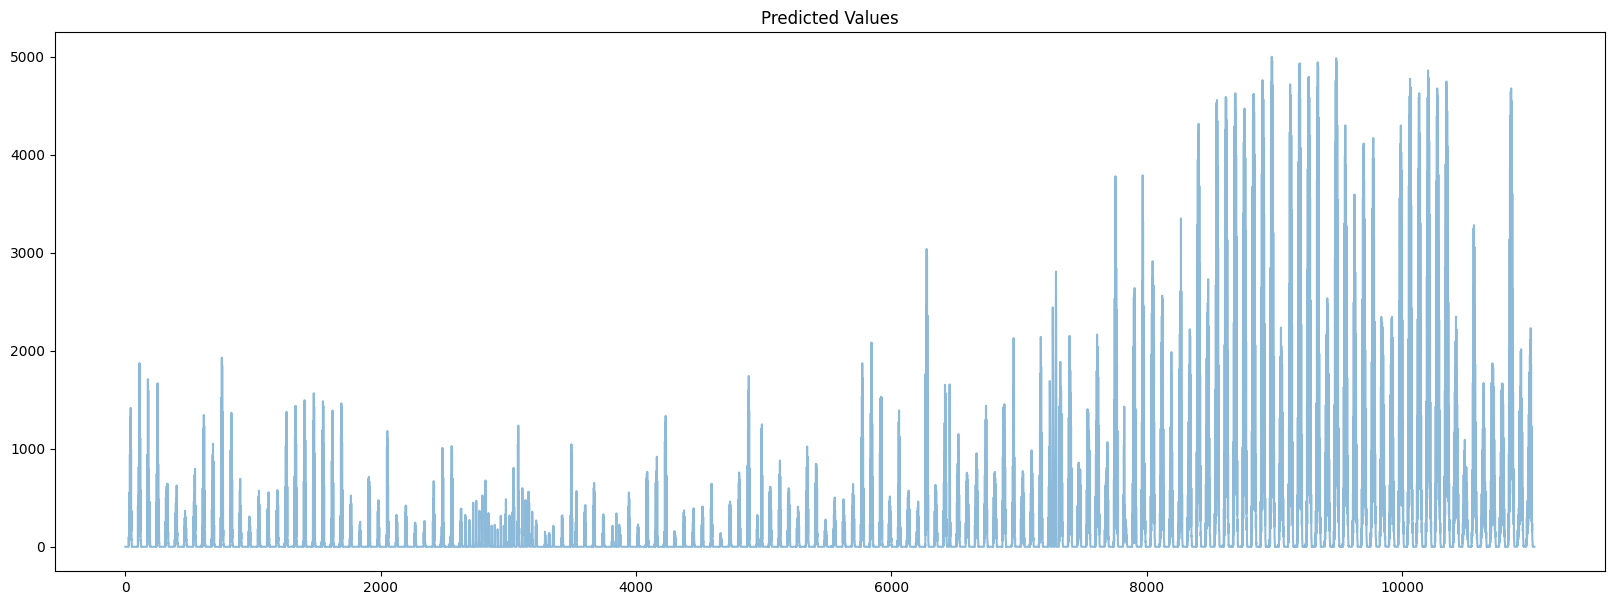

In [32]:
plt.figure(figsize=(20, 7))
plt.plot(df_best_preds['avg'], alpha=0.5)
plt.title('Predicted Values')
plt.show()

In [28]:
from sklearn.linear_model import LinearRegression

LR_model = LinearRegression()
LR_model.fit(df_best_preds.iloc[: , :N], y_train_est) # Select dataset of choice

LinearRegression()

In [34]:
print("MAE: ", mean_absolute_error(y_train_est, df_best_preds['avg']))

MAE:  83.69711392474223


In [35]:
# Make kaggle prediction
best_kaggle_preds = []

for i in range(N):
    best_kaggle_preds.append(nets[i].predict(X_kaggle).ravel())
    # TODO: test against best sub    print(i, "MAE: ", mean_absolute_error(y_val_test, best_preds[i]))

68/68 [==============================] - 0s 575us/step


In [46]:
# Create dataframe for kaggle pred
df_kaggle_preds = pd.DataFrame(best_kaggle_preds).T

#df_kaggle_preds['avg'] = df_kaggle_preds.mean(axis='columns')

kaggle_pred = LR_model.predict(df_kaggle_preds.iloc[: , :N])
kaggle_pred = kaggle_pred.clip(min=0)

In [47]:
# Merge with kaggle_test data and sort after date_forecast
test_ALL_to_sub = pd.read_csv("current_csv_files/test_ALL.csv")
test_ALL_to_sub['prediction'] = kaggle_pred

#test_ALL_to_sub['avg'] = df_kaggle_preds['avg']

In [48]:
# Correctly sort test data for submission
test_ALL_sorted = test_ALL_to_sub.sort_values(['A', 'B', 'C', 'date_forecast'], ascending=[False, False, False, True])
test_ALL_sorted['id'] = range(2160)

MAE:  736.3859041788337


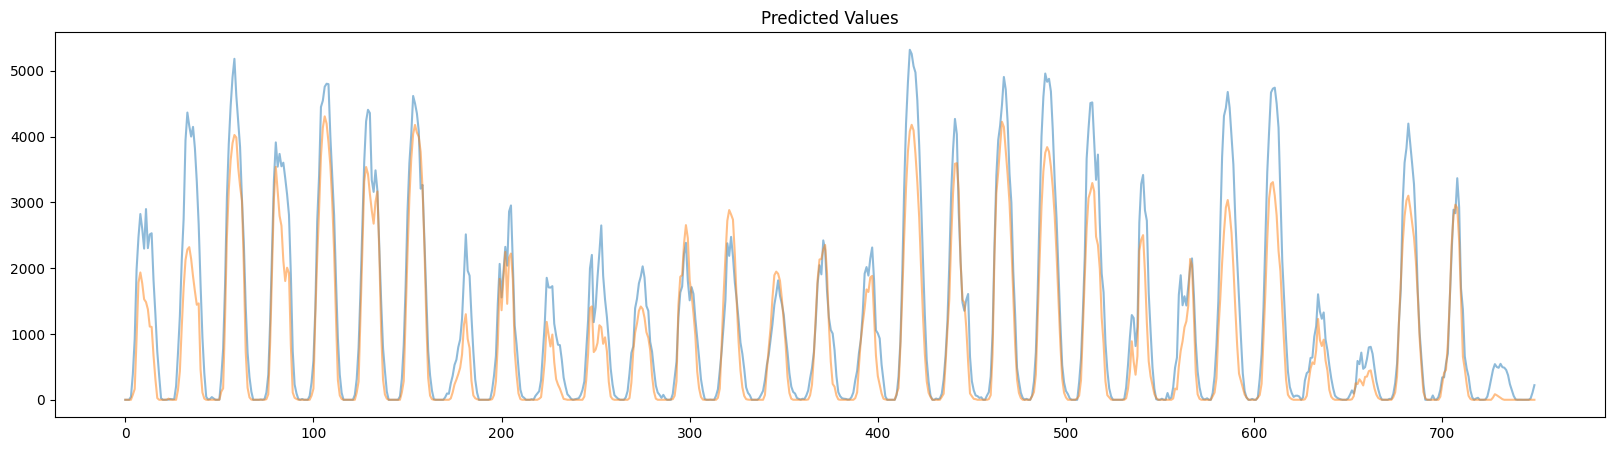

In [49]:
# Comparison to best sub on kaggle

best_sub = pd.read_csv("teo_subs/best_sub.csv", index_col='id')
print("MAE: ", mean_absolute_error(best_sub, kaggle_pred))

slide = 0
start = 0 + slide
stop = 750 + slide

plt.figure(figsize=(20, 5))
plt.plot(range(start, stop), best_sub.iloc[start:stop], alpha=0.5)
plt.plot(range(start, stop), test_ALL_sorted['prediction'].iloc[start:stop], alpha=0.5)
plt.title('Predicted Values')
plt.show()

In [50]:
test_ALL_sorted[['id', 'prediction']].to_csv("teo_subs/teo_sub_5.csv", index=False)